# Vertraagd: Een analyse van treinvertragingen in België

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

In [19]:
df = pd.read_csv("../data_punctualite_typedetrain.csv", sep=";")

Treinvertragingen, afschaffingen, stakingen — we kennen het allemaal. Voor duizenden pendelaars in België vormen ze een dagelijkse bron van frustratie. Maar hoe ernstig zijn die vertragingen eigenlijk? En valt er een patroon te ontdekken, bijvoorbeeld in het tijdstip of het type trein?

In dit project duiken we in een dataset van [Infrabel](https://opendata.infrabel.be/explore/dataset/data_punctualite_typedetrain/table/?disjunctive.rel&sort=maand). We zoeken uit hoe vaak vertragingen voorkomen, wanneer ze zich het vaakst voordoen, en welke treintypes het kwetsbaarst zijn. Zo proberen we grip te krijgen op een probleem waar velen dagelijks mee te maken krijgen.

## Treintypes

Niet elke trein is hetzelfde — er zijn stoptreinen, sneltreinen, en zelfs internationale treinen. Aan de hand van hun afkortingen is het meestal eenvoudig te achterhalen met welk type je reist.

| Afkorting    | Betekenis |
| -------- | ------- |
| IC | InterCity, haltes in de belangrijkste steden |
| P | Piekuur, rijdt op drukke momenten, extra treinen. |
| L | Lokale trein, stopt aan elke halte op het pad, (todo) |
| S | Stoptrein, rijdt in voorstedelijke gebieden |
| INT | Klassieke interantionale treinen |
| ICT | Toeristische treinen |

Bron: [Wikipedia](https://nl.wikipedia.org/wiki/Lijst_van_treincategorie%C3%ABn_in_Belgi%C3%AB)

Maar hoe vaak komt elk treintype voor in de dataset? Om daar een visueel beeld van te krijgen, gebruiken we een waffle chart.

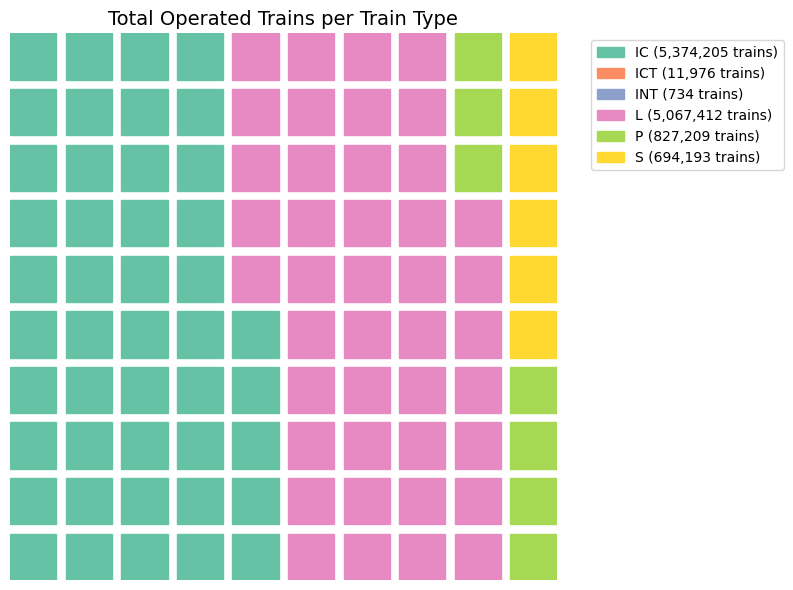

In [20]:
from pywaffle import Waffle
import matplotlib.pyplot as plt
import pandas as pd

# Group by train type and sum the number of operated trains
trains_per_type = df.groupby('Train type')['Number of operated trains'].sum()

# Scale to a total of 100 blocks
total_blocks = 100
scaled_values = (trains_per_type / trains_per_type.sum() * total_blocks).round().astype(int)

# Create the waffle chart (fill row by row, left to right)
fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=scaled_values.to_dict(),
    vertical=False,  # Fill row by row (left to right)
    title={'label': 'Total Operated Trains per Train Type', 'loc': 'center', 'fontsize': 14},
    labels=[f"{k} ({v:,} trains)" for k, v in trains_per_type.items()],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.05, 1)},
    figsize=(12, 6)
)

plt.show()

# Probleem: je ziet ICT en INT niet omdat er te weinig zijn (met 1000 blokjes nog steeds INT niet en groter niet ok)

De visualisatie maakt meteen duidelijk dat sommige treintypes veel vaker voorkomen dan andere. Om die verschillen verder te onderzoeken, kijken we ook naar hoe de aanwezigheid van elk treintype doorheen de tijd evolueert.

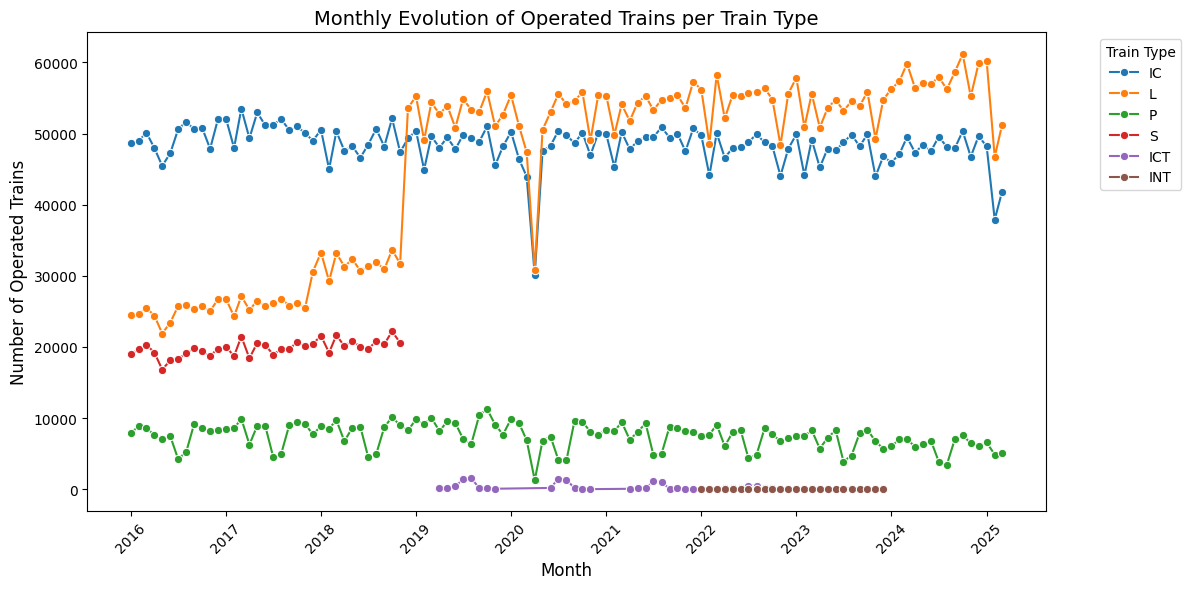

In [21]:
# Ensure 'Month' is in datetime format
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

# Group by month and train type, summing the number of operated trains
monthly_trains = df.groupby(['Month', 'Train type'], as_index=False)['Number of operated trains'].sum()

# Set up the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trains, x='Month', y='Number of operated trains', hue='Train type', marker='o')

# Customize
plt.title("Monthly Evolution of Operated Trains per Train Type", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Operated Trains", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Train Type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Wat opvalt: slechts drie treintypes (IC, P, L) komen consistent voor in elk jaar van de dataset. Andere types, zoals ICT, INT en S, zijn maar gedurende een korte periode opgenomen. Dit kan een vertekend beeld geven van de algemene trends.

Daarom nemen we deze treintypes niet altijd mee in verdere vergelijkingen of verbanden. Zo houden we de analyses representatief en vermijden we foutieve conclusies.

## Verdere inzichten

Wanneer we de stiptheid van de treinen door de jaren heen bekijken, kunnen we mogelijk trends ontdekken: is de situatie verbeterd of net verslechterd? Hieronder tonen we dat aan de hand van een interactieve line chart.

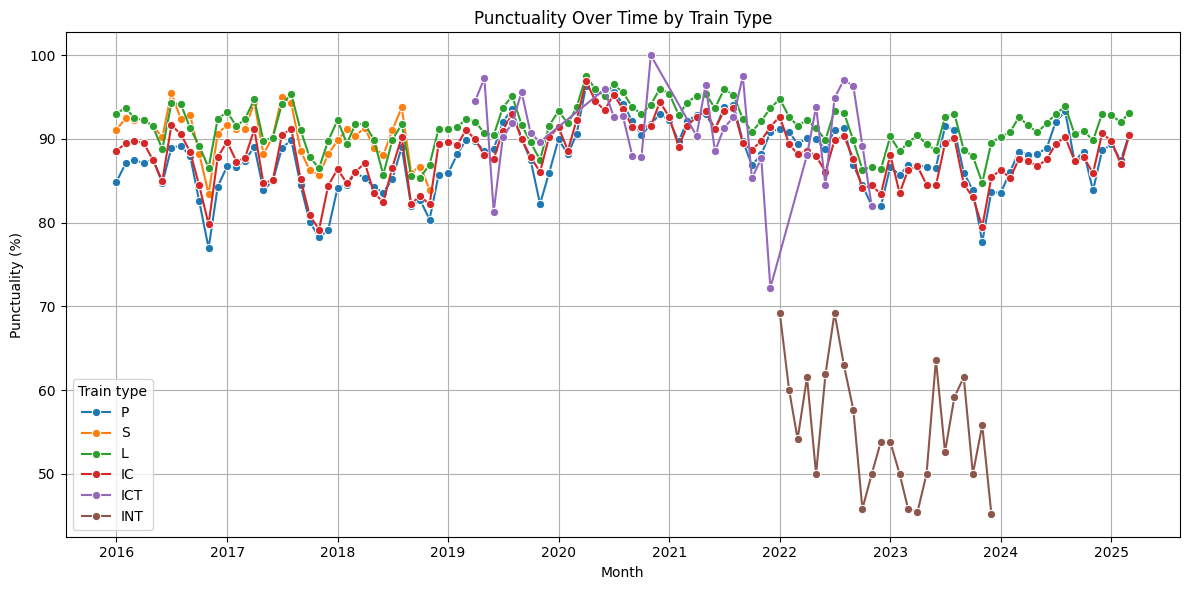

In [22]:
# Convert Month to datetime format
df['Month'] = pd.to_datetime(df['Month'])

# Sort by date to ensure the line chart is chronological
df = df.sort_values('Month')

# Plot punctuality over time per train type
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Month', y='Punctuality', hue='Train type', marker='o')

plt.title("Punctuality Over Time by Train Type")
plt.xlabel("Month")
plt.ylabel("Punctuality (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

Hoewel we niet voor elk treintype gegevens uit elk jaar hebben, springt één ding meteen in het oog: de INT-trein scoort het slechtst op stiptheid. Daarnaast blijft de algemene stiptheid doorheen de jaren vrij stabiel rond de 90%, met hier en daar lichte schommelingen.

Om te onderzoeken of het seizoen invloed heeft op de vertragingen, visualiseren we per treintype de gemiddelde vertraging per seizoen.

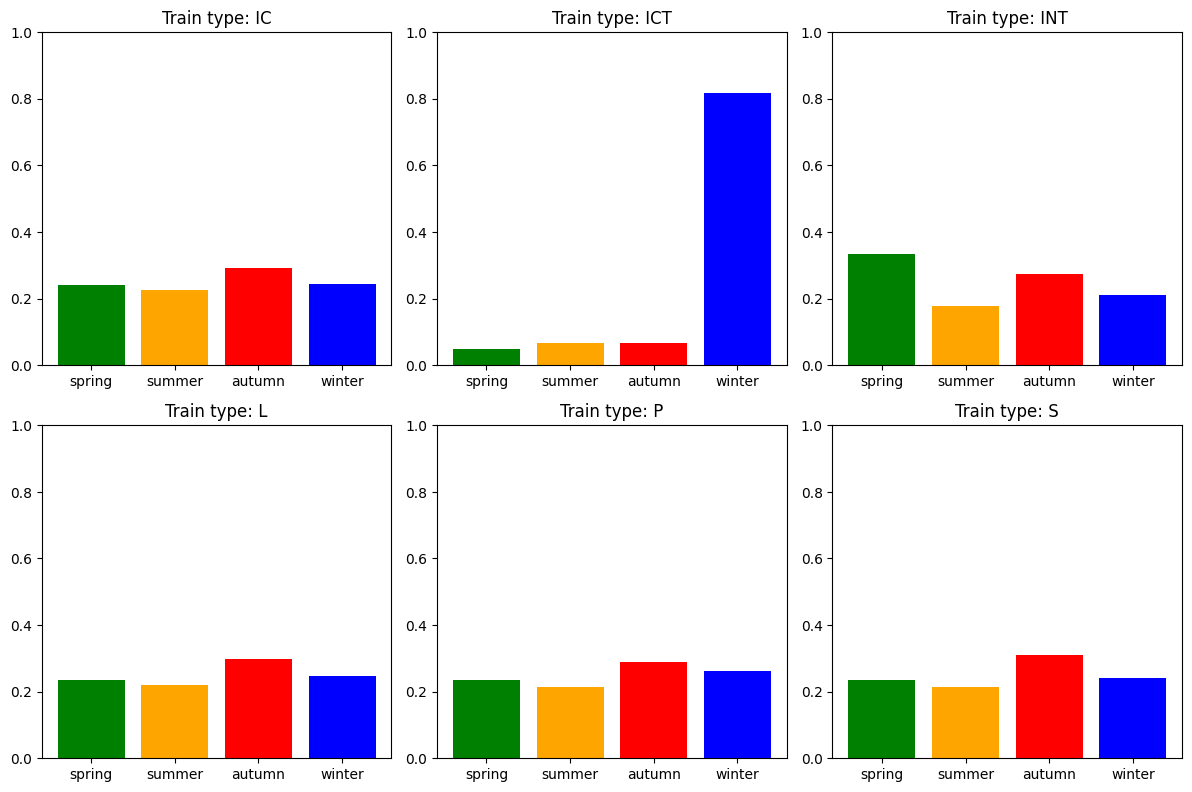

In [23]:
import polars as rs

dfrs = rs.read_csv("../data_punctualite_typedetrain.csv", separator=';')

def month_to_season(month: int) -> str:
    if month in [1, 2, 12]:
        return "winter"
    if month in [3, 4, 5]:
        return "spring"
    if month in [6, 7, 8]:
        return "summer"
    return "autumn"

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.flatten()
train_types = ["IC", "ICT", "INT", "L", "P", "S"]

season_order = {'spring': 0, 'summer': 1, 'autumn': 2, 'winter': 3}

df_season = dfrs.with_columns(
    rs.col("Month") \
        .map_elements(lambda e: month_to_season(int(e.split("-")[1])), return_dtype=rs.String) \
        .alias("Season")
)

df_sum_train_season = df_season.group_by(["Train type", "Season"]).agg([
    rs.col("Minutes of delay").sum().alias("total_delay"),
    rs.col("Number of operated trains").sum().alias("total_trains")
])

df_avg = df_sum_train_season.with_columns(
    (rs.col("total_delay") / rs.col("total_trains")).alias("Normalized delay")
)

total_sum_season = df_avg.select("Normalized delay").sum()[0, 0]

df_normalized = df_avg.sort(rs.col("Season").replace_strict(season_order)) \
    .with_columns((rs.col("Normalized delay") / total_sum_season).alias("Normalized^2 delay"))

colors = {
    "spring": "green",
    "summer": "orange",
    "autumn": "red",
    "winter": "blue"
}

for i in range(len(ax)):
    frame = df_normalized.filter(rs.col("Train type") == train_types[i])
    summed = frame.select("Normalized delay").sum()[0, 0]

    normalized_frame = frame.with_columns((rs.col("Normalized delay") / summed).alias("Normalized^2 delay"))

    ax[i].bar(normalized_frame["Season"], normalized_frame["Normalized^2 delay"], color=[colors[s] for s in normalized_frame["Season"]])
    ax[i].set_title("Train type: " + train_types[i])
    ax[i].set_ylim(0, 1)

plt.tight_layout(pad=1.0)
plt.show()


Op basis van al deze grafieken samen kunnen we echter geen duidelijk verband vaststellen tussen seizoen en vertraging. Zo zien we geen algemene trend over al de treintypes heen. De variaties lijken eerder willekeurig dan seizoensgebonden. Echter, als we ons beperken tot de 3 treintypes waarvoor we over alle jaren consistente data hebben, valt er wel iets interessants op. 

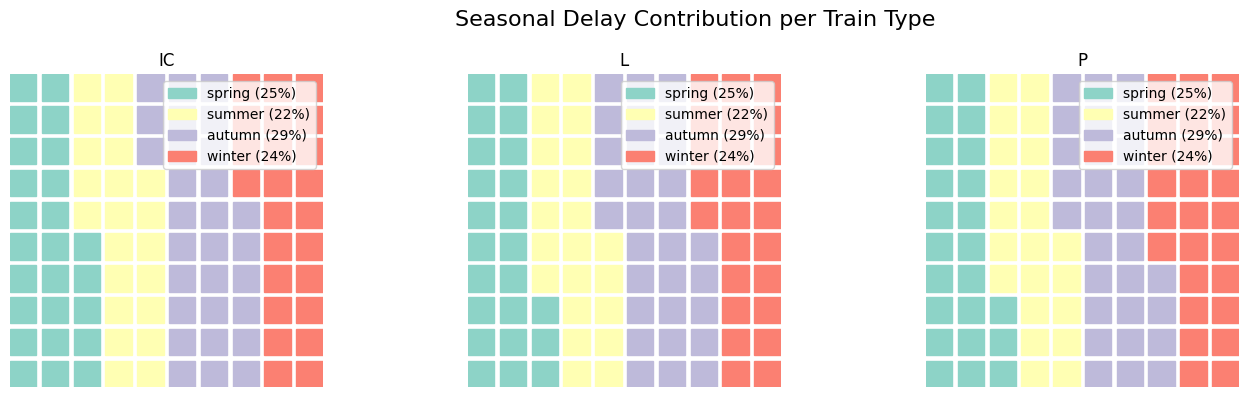

In [24]:
season_order = {'spring': 0, 'summer': 1, 'autumn': 2, 'winter': 3}
season_colors = {
    'spring': '#8dd3c7',
    'summer': '#ffffb3',
    'autumn': '#bebada',
    'winter': '#fb8072'
}

# Add season column
df_season = dfrs.with_columns(
    rs.col("Month") \
        .map_elements(lambda e: month_to_season(int(e.split("-")[1])), return_dtype=rs.String) \
        .alias("Season")
)

# Delay calculation
df_sum_train_season = df_season \
    .filter(rs.col("Train type").is_in(train_types)) \
    .group_by(["Train type", "Season"]) \
    .agg([
        rs.col("Minutes of delay").sum().alias("total_delay"),
        rs.col("Number of operated trains").sum().alias("total_trains")
    ])

df_avg = df_sum_train_season.with_columns(
    (rs.col("total_delay") / rs.col("total_trains")).alias("Normalized delay")
)

df_train_type_sum = df_avg.group_by("Train type").agg(
    rs.col("Normalized delay").sum().alias("Total sum per train type")
)

joined = df_avg.join(df_train_type_sum, on="Train type", how="inner")

df_normalized = joined \
    .with_columns((rs.col("Normalized delay") / rs.col("Total sum per train type")) \
         .alias("Normalized delay train type")
    )  \
    .sort(rs.col("Season").replace_strict(season_order))

# Convert to pandas dataframe for PyWaffle
df_plot = df_normalized.select(["Train type", "Season", "Normalized delay train type"]).to_pandas()

# Color mapping
season_colors = {
    'spring': '#8dd3c7',
    'summer': '#ffffb3',
    'autumn': '#bebada',
    'winter': '#fb8072'
}

# Waffle data prep per train type
train_types = ["IC", "L", "P"]
waffle_data = {}

for train in train_types:
    temp_df = df_plot[df_plot["Train type"] == train]
    values = (temp_df.set_index("Season")["Normalized delay train type"] * 100).round().astype(int).to_dict()

    # Fix rounding discrepancies
    diff = 100 - sum(values.values())
    if diff != 0:
        first_key = next(iter(values))
        values[first_key] += diff

    waffle_data[train] = values

# Plot using PyWaffle
fig = plt.figure(
    FigureClass=Waffle,
    plots={
        131: {
            'values': waffle_data["IC"],
            'labels': [f"{k} ({v}%)" for k, v in waffle_data["IC"].items()],
            'title': {'label': 'IC', 'loc': 'center'},
            'colors': [season_colors[k] for k in waffle_data["IC"].keys()]
        },
        132: {
            'values': waffle_data["L"],
            'labels': [f"{k} ({v}%)" for k, v in waffle_data["L"].items()],
            'title': {'label': 'L', 'loc': 'center'},
            'colors': [season_colors[k] for k in waffle_data["L"].keys()]
        },
        133: {
            'values': waffle_data["P"],
            'labels': [f"{k} ({v}%)" for k, v in waffle_data["P"].items()],
            'title': {'label': 'P', 'loc': 'center'},
            'colors': [season_colors[k] for k in waffle_data["P"].keys()]
        }
    },
    rows=10,
    figsize=(14, 4)
)

fig.suptitle("Seasonal Delay Contribution per Train Type", fontsize=16)
plt.tight_layout()
plt.show()

Elk van deze treinen vertoont een duidelijk seizoenspatroon in de gemiddelde vertraging: de herfst kent de hoogste vertragingen, gevolgd door de winter, daarna de lente, en ten slotte de zomer, die het best scoort.

Om te achterhalen of één bepaald treintype veel meer bijdraagt aan de totale vertragingen dan een andere, visualiseren we de gegevens in een boxplot. Deze grafiek geeft ons een gedetailleerd beeld van de spreiding en verdeling van vertragingen per treintype. Hier laten we opnieuw de treintypes weg die niet frequent voorkomen in de dataset.

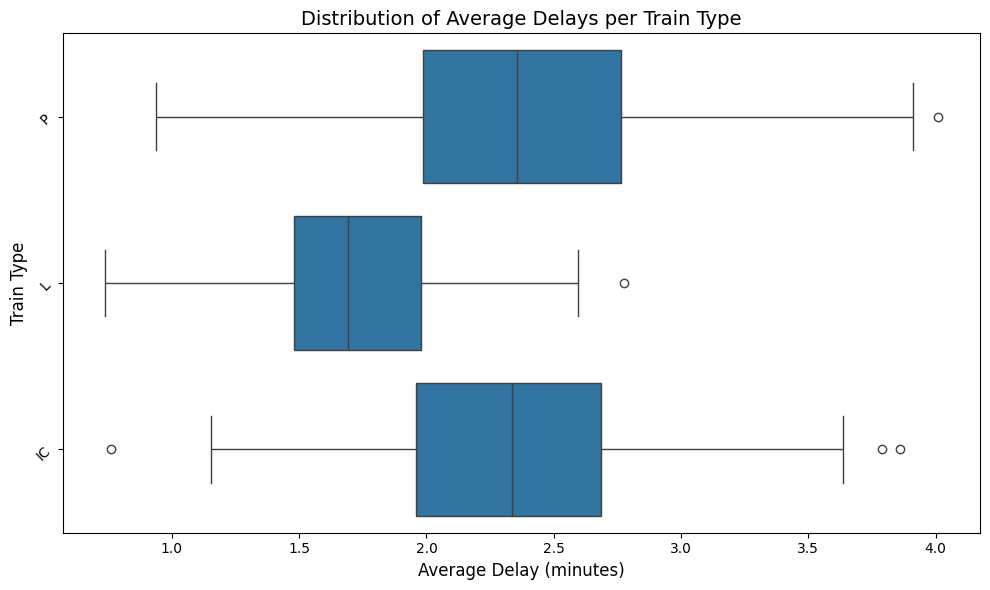

In [25]:
### RELATIEF

# Recalculate Average Delay per entry (if not already in your df)
df['Average Delay'] = df['Minutes of delay'] / df['Number of operated trains']

# Filter out the ICT, INT, and S train types
filtered_df = df[~df['Train type'].isin(['ICT', 'INT', 'S'])]

# Create the boxplot: distribution of average delay per train type
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, y='Train type', x='Average Delay')

# Customize the plot
plt.title("Distribution of Average Delays per Train Type", fontsize=14)
plt.xlabel("Average Delay (minutes)", fontsize=12)
plt.ylabel("Train Type", fontsize=12)

# Optional: rotate y labels if they overlap
plt.yticks(rotation=45)

plt.tight_layout()
plt.show()

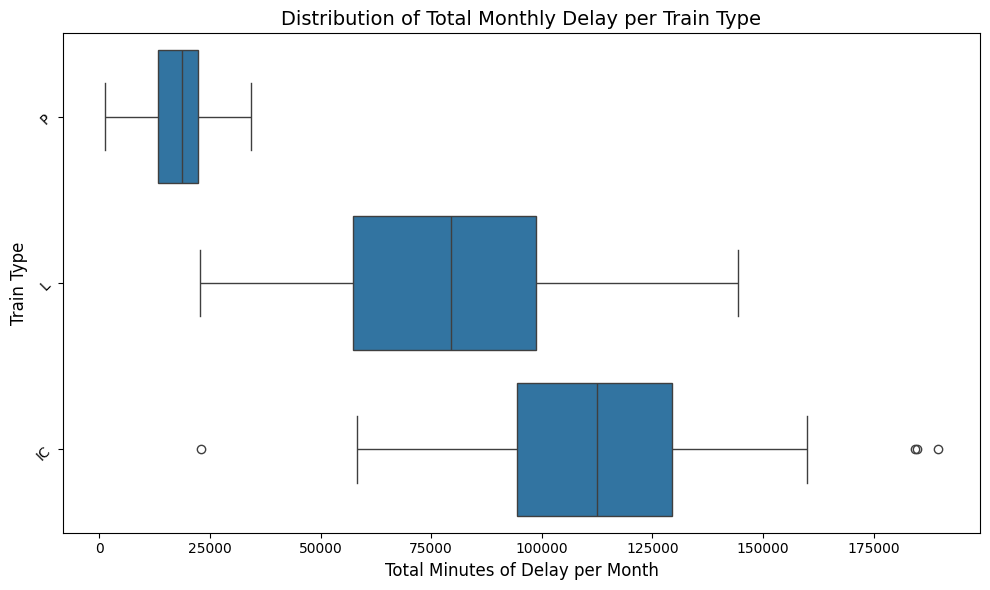

In [26]:
### ABSOLUUT
# Convert 'Month' to datetime for good measure
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

# Filter out the ICT, INT, and S train types
filtered_df = df[~df['Train type'].isin(['ICT', 'INT', 'S'])]

# Keep only relevant columns
delay_by_type = filtered_df[['Train type', 'Minutes of delay']].copy()

# Create the boxplot: distribution of total monthly delay per train type
plt.figure(figsize=(10, 6))
sns.boxplot(data=delay_by_type, y='Train type', x='Minutes of delay')

# Customize
plt.title("Distribution of Total Monthly Delay per Train Type", fontsize=14)
plt.ylabel("Train Type", fontsize=12)
plt.xlabel("Total Minutes of Delay per Month", fontsize=12)
plt.yticks(rotation=45)

plt.tight_layout()
plt.show()

Voor extra duidelijkheid tonen we zowel relatieve als absolute cijfers:
- De relatieve vertragingen zijn gemiddelden, berekend door de totale vertraging te delen door het aantal gereden treinen.
- De absolute vertragingen tonen het totaal aan vertraging per type, en geven zo weer hoe ernstig de impact kan zijn in omvang.

Deze combinatie laat toe om niet alleen te zien hoe vaak treinen vertraging hebben, maar ook hoe zwaar die vertragingen doorwegen per treintype.

## Conclusie

Hoewel het seizoen geen eenduidig beeld geeft over wanneer de vertragingen het ergst zijn, zien we wel een duidelijker patroon als we naar het type trein kijken.

De IC-trein, die ook het vaakst voorkomt in de dataset, vertoont gemiddeld meer minuten vertraging dan de andere treinen — dit op basis van de 3 treintypes waarvoor we over alle jaren data hebben.

Kijken we daarentegen naar alle treinen, dan valt de INT-trein op als de minst stipte. Toch moeten we daar voorzichtig mee zijn: omdat er van de INT-trein geen data is over alle jaren, kunnen we daaruit geen conclusies trekken.

De onderstaande area chart toont duidelijk hoe de IC-trein door de jaren heen het grootste aandeel aan vertragingen heeft veroorzaakt.

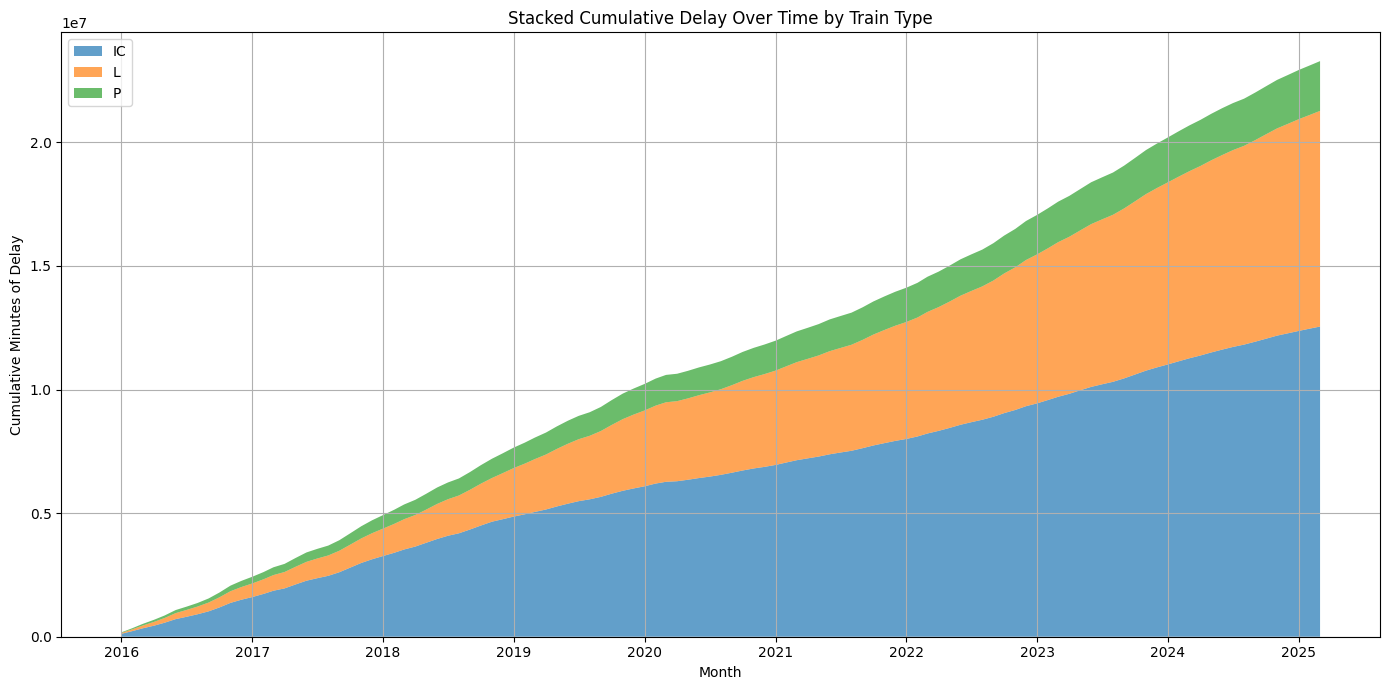

In [27]:
# Step 1: Prep cumulative delay per train type per month
df_filtered = df[~df['Train type'].isin(['ICT', 'INT', 'S'])]  # Exclude unwanted train types
df_filtered = df_filtered.sort_values('Month')
df_filtered['Cumulative delay'] = df_filtered.groupby('Train type')['Minutes of delay'].cumsum()

# Step 2: Pivot to wide format (each train type is a column)
cumulative_pivot = df_filtered.pivot(index='Month', columns='Train type', values='Cumulative delay').fillna(0)

# Step 3: Plot as stacked area chart
plt.figure(figsize=(14, 7))
plt.stackplot(cumulative_pivot.index, cumulative_pivot.T.values, labels=cumulative_pivot.columns, alpha=0.7)

plt.title('Stacked Cumulative Delay Over Time by Train Type')
plt.ylabel('Cumulative Minutes of Delay')
plt.xlabel('Month')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()